In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
# %matplotlib qt
import sys
sys.path.append('C:\code\qdc2')
import matplotlib.pyplot as plt 
import os 
import numpy as np 
from qdc.mmf.many_wl_fiber import ManyWavelengthFiber
from qdc.mmf.qdc_experiment import QDCMMFExperiment
from qdc.misc import tnow
DATA_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, '..', 'data')))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MMF

In [ ]:
def run_mmf(is_step_index=False):
    fiber_L = 0.1e6  if is_step_index else 2e6 # um 
    N_wl = 81
    N_classical = 5
    N_SPDC = 5
    wl0 = 0.810
    Dwl = 0.020 if is_step_index else 0.020
    NA_ref = 0.2   
    dzs = [0, 10, 50, 200, 1000] if is_step_index else [0, 10, 50, 80]
    free_mode_matrix = True  # when working with 2**8, the RAM explodes 
    autosolve = not free_mode_matrix  # if freeing each time - no point in autosolving initially 

    npoints = 2**8
    n_pixels_diameter = 2*npoints//5 if is_step_index else npoints//4
    s = ManyWavelengthFiber(wl0=wl0, Dwl=Dwl, N_wl=N_wl, fiber_L=fiber_L, rng_seed=5555, is_step_index=is_step_index, 
                            npoints=npoints, NA_ref=NA_ref, autosolve=autosolve)
    s.gaussian_params = np.array([2.7, 7, 10, 0.5, 0.5]) 
    s.gaussian_dparams = np.array([1, 5, 5, 0.3, 0.3])
    # s.gaussian_dparams = np.array([0, 4, 4, 0.1, 0.1])

    exp = QDCMMFExperiment(s, free_mode_matrix=free_mode_matrix)
    exp._set_PCC_slice(n_pixels_diameter=n_pixels_diameter)
    res = exp.run_PCCs_different_dz(dzs=dzs, N_classical=N_classical, N_SPDC=N_SPDC)

    f_type = 'SI' if is_step_index else 'GRIN'
    saveto_path = rf'{DATA_DIR}\\{tnow()}_{f_type}_{round(fiber_L*1e-6, 2)}m_N=100.npz'
    res.saveto(saveto_path)
    return res

res_SI = run_mmf(is_step_index=False)
res_GRIN = run_mmf(is_step_index=True)

Getting 81 fibers...


81it [00:04, 18.92it/s]


Got fibers!
Getting classical with average on 5 ...


Running classical measurements:  20%|██        | 1/5 [01:05<04:22, 65.51s/it]

## View results 

In [ ]:
res = res_SI
iter_no = None
dz = 0
print(res.metadata["g_params_list"][iter_no or 0])
res.show(title='', iter_no=iter_no, show0=False)
# for i in range(5):
    # res.show_incoherent_sum(iter_no=i, dz=dz)
    # res.show(title='', iter_no=i, show0=False)

res.show_incoherent_sum(iter_no=iter_no, dz=dz)

## View input and output fields + mode distribution for given gaussian params 

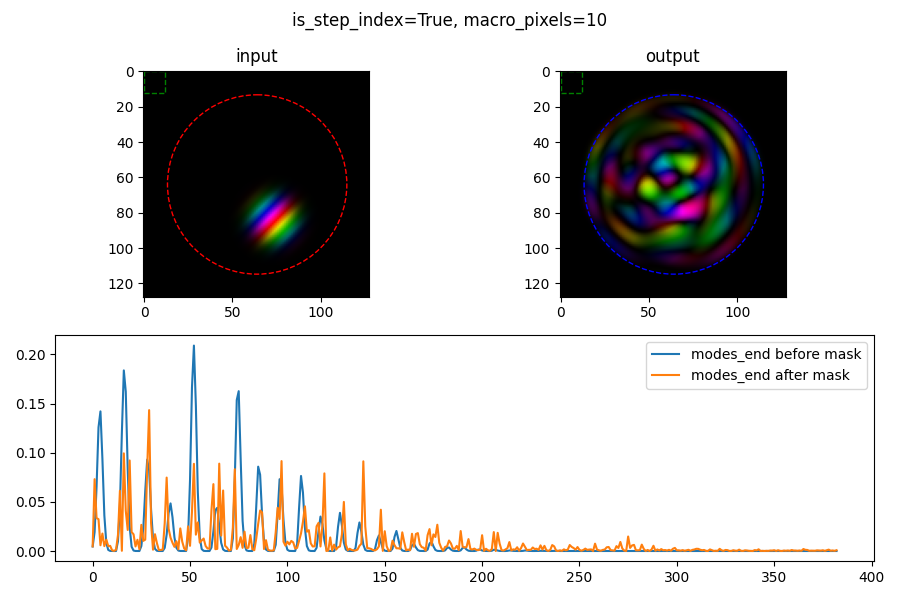

In [5]:
import cv2
from qdc.mmf.fiber import Fiber

is_step_index = True
f = Fiber(is_step_index=is_step_index)
f.set_input_gaussian(sigma=3, X0=5, Y0=10, X_linphase=0.4, Y_linphase=0.4, random_phase=0.0)
f.propagate(False)

fig, axes = plt.subplot_mosaic(
    [["left", "right"],
     ["bottom", "bottom"]],
    figsize=(9, 6)
)

from matplotlib import patches
# make circle centered in the middle of the plot
circle = patches.Circle((f.npoints//2, f.npoints//2), 25/f.index_profile.dh, color='red', fill=False, linestyle='dashed')
axes["left"].add_patch(circle)
circle = patches.Circle((f.npoints//2, f.npoints//2), 25/f.index_profile.dh, color='blue', fill=False, linestyle='dashed')
axes["right"].add_patch(circle)


f.show_profile(f.profile_0,   ax=axes["left"],   title='input')
f.show_profile(f.profile_end, ax=axes["right"],  title='output')

# axes["bottom"].plot(np.abs(f.modes_0)**2, label='modes 0')
axes["bottom"].plot(np.abs(f.modes_0)**2, label='modes_end before mask')

macro_pixels = 10
square_size = f.npoints//macro_pixels
square = patches.Rectangle((0,0), square_size, square_size, color='green', fill=False, linestyle='dashed')
axes["left"].add_patch(square)
square = patches.Rectangle((0,0), square_size, square_size, color='green', fill=False, linestyle='dashed')
axes["right"].add_patch(square)

A = np.random.uniform(0, 2*np.pi, size=(macro_pixels, macro_pixels))
A = cv2.resize(A, (f.npoints.item(), f.npoints.item()), interpolation=cv2.INTER_AREA)
A = np.exp(1j*A)
profile_after_mask = f.profile_end * A.ravel()
modes_after_mask = f.modes.getModeMatrix().T @ profile_after_mask

axes["bottom"].plot(np.abs(modes_after_mask)**2, label='modes_end after mask')

axes["bottom"].legend()
fig.suptitle(f'is_step_index={is_step_index}, macro_pixels={macro_pixels}')
plt.tight_layout()